## TUTORIAL 06 - Unsteady Thermal block problem
**_Keywords: POD-Galerkin method, scalar problem_**

### 1. Introduction
In this Tutorial, we consider unsteady heat conduction in a two-dimensional domain $\Omega$.

We define two subdomains $\Omega_1$ and $\Omega_2$, such that
1. $\Omega_1$ is a disk centered at the origin of radius $r_0=0.5$, and
2. $\Omega_2=\Omega/\ \overline{\Omega_1}$. 

The conductivity $\kappa$ is assumed to be constant on $\Omega_1$ and $\Omega_2$, i.e.
$$
\kappa|_{\Omega_1}=\kappa_0 \quad \textrm{and} \quad \kappa|_{\Omega_2}=1.
$$

For this problem, we consider $P=2$ parameters:
1. the first one is related to the conductivity in $\Omega_1$, i.e. $\mu_0\equiv\kappa_0$ (_note that parameters numbering is zero-based_);
2. the second parameter $\mu_1$ takes into account the constant heat flux over $\Gamma_{base}$.

The parameter vector $\boldsymbol{\mu}$ is thus given by 
$$
\boldsymbol{\mu} = (\mu_0,\mu_1)
$$
on the parameter domain
$$
\mathbb{P}=[0.1,10]\times[-1,1].
$$

In this problem we model the heat transfer process due to the heat flux over the bottom boundary $\Gamma_{base}$ and the following conditions on the remaining boundaries:
* the left and right boundaries $\Gamma_{side}$ are insulated,
* the top boundary $\Gamma_{top}$ is kept at a reference temperature (say, zero),

with the aim of measuring the average temperature on $\Gamma_{base}$.

In order to obtain a faster approximation of the problem we pursue a model reduction by means of a POD-Galerkin reduced order method.

### 2. Parametrized formulation

Let $u(t;\boldsymbol{\mu})$ be the temperature in the domain $\Omega\times[0,t_f]$.

The strong formulation of the parametrized problem is given by: for a given parameter $\boldsymbol{\mu}\in\mathbb{P}$, for $t\in[0,t_f]$, find $u(t;\boldsymbol{\mu})$ such that

$$
\begin{cases}
	\partial_tu(t;\boldsymbol{\mu})- \text{div} (\kappa(\mu_0)\nabla u(t;\boldsymbol{\mu})) = 0 & \text{in } \Omega\times[0,t_f],\\
    u(t=0;\boldsymbol{\mu}) = 0 & \text{in } \Omega, \\ 
	u(t;\boldsymbol{\mu}) = 0 & \text{on } \Gamma_{top}\times[0,t_f],\\
	\kappa(\mu_0)\nabla u(t;\boldsymbol{\mu})\cdot \mathbf{n} = 0 & \text{on } \Gamma_{side}\times[0,t_f],\\
	\kappa(\mu_0)\nabla u(t;\boldsymbol{\mu})\cdot \mathbf{n} = \mu_1 & \text{on } \Gamma_{base}\times[0,t_f].
\end{cases}
$$
<br>

where 
* $\mathbf{n}$ denotes the outer normal to the boundaries $\Gamma_{side}$ and $\Gamma_{base}$,
* the conductivity $\kappa(\mu_0)$ is defined as follows:
$$
\kappa(\mu_0) =
\begin{cases}
	\mu_0 & \text{in } \Omega_1,\\
	1 & \text{in } \Omega_2,\\
\end{cases}
$$

The corresponding weak formulation reads: for a given parameter $\boldsymbol{\mu}\in\mathbb{P}$, for $t\in[0,t_f]$, find $u(t;\boldsymbol{\mu})\in\mathbb{V}$ such that

$$m\left(\partial_tu(t;\boldsymbol{\mu}),v;\boldsymbol{\mu}\right) + a\left(u(t;\boldsymbol{\mu}),v;\boldsymbol{\mu}\right)=f(v;\boldsymbol{\mu})\quad \forall v\in\mathbb{V},\quad \forall t\in[0,t_f]$$

where

* the function space $\mathbb{V}$ is defined as
$$
\mathbb{V} = \{v\in H^1(\Omega) : v|_{\Gamma_{top}}=0\}
$$
* the parametrized bilinear form $m(\cdot, \cdot; \boldsymbol{\mu}): \mathbb{V} \times \mathbb{V} \to \mathbb{R}$ is defined by
$$m(u, v;\boldsymbol{\mu})=\int_{\Omega} \partial_tu(t)v \ d\boldsymbol{x},$$
* the parametrized bilinear form $a(\cdot, \cdot; \boldsymbol{\mu}): \mathbb{V} \times \mathbb{V} \to \mathbb{R}$ is defined by
$$a(u, v;\boldsymbol{\mu})=\int_{\Omega} \kappa(\mu_0)\nabla u\cdot \nabla v \ d\boldsymbol{x},$$
* the parametrized linear form $f(\cdot; \boldsymbol{\mu}): \mathbb{V} \to \mathbb{R}$ is defined by
$$f(v; \boldsymbol{\mu})= \mu_1\int_{\Gamma_{base}}v \ ds,$$

The (compliant) output of interest $s(t;\boldsymbol{\mu})$ is given by
$$s(t;\boldsymbol{\mu}) = \mu_1\int_{\Gamma_{base}} u(t;\boldsymbol{\mu})$$
is computed for each $\boldsymbol{\mu}$.

In [1]:
import os
import sys
sys.path.append('../../')

from mlnics import NN, Losses, Normalization, RONNData, IO, Training, ErrorAnalysis
from dolfin import *
from rbnics import *
import torch
import numpy as np

torch.manual_seed(0)
np.random.seed(0)

## 3. Affine decomposition

For this problem the affine decomposition is straightforward:
$$m(u,v;\boldsymbol{\mu})=\underbrace{1}_{\Theta^{m}_0(\boldsymbol{\mu})}\underbrace{\int_{\Omega}uv \ d\boldsymbol{x}}_{m_0(u,v)},$$
$$a(u,v;\boldsymbol{\mu})=\underbrace{\mu_0}_{\Theta^{a}_0(\boldsymbol{\mu})}\underbrace{\int_{\Omega_1}\nabla u \cdot \nabla v \ d\boldsymbol{x}}_{a_0(u,v)} \ + \  \underbrace{1}_{\Theta^{a}_1(\boldsymbol{\mu})}\underbrace{\int_{\Omega_2}\nabla u \cdot \nabla v \ d\boldsymbol{x}}_{a_1(u,v)},$$
$$f(v; \boldsymbol{\mu}) = \underbrace{\mu_1}_{\Theta^{f}_0(\boldsymbol{\mu})} \underbrace{\int_{\Gamma_{base}}v \ ds}_{f_0(v)}.$$
We will implement the numerical discretization of the problem in the class
```
class UnsteadyThermalBlock(ParabolicCoerciveProblem):
```
by specifying the coefficients $\Theta^{m}_*(\boldsymbol{\mu})$, $\Theta^{a}_*(\boldsymbol{\mu})$ and $\Theta^{f}_*(\boldsymbol{\mu})$ in the method
```
    def compute_theta(self, term):     
```
and the bilinear forms $m_*(u, v)$, $a_*(u, v)$ and linear forms $f_*(v)$ in
```
    def assemble_operator(self, term):
```

In [2]:
class UnsteadyThermalBlock(ParabolicCoerciveProblem):

    # Default initialization of members
    def __init__(self, V, **kwargs):
        # Call the standard initialization
        ParabolicCoerciveProblem.__init__(self, V, **kwargs)
        # ... and also store FEniCS data structures for assembly
        assert "subdomains" in kwargs
        assert "boundaries" in kwargs
        self.subdomains, self.boundaries = kwargs["subdomains"], kwargs["boundaries"]
        self.u = TrialFunction(V)
        self.v = TestFunction(V)
        self.dx = Measure("dx")(subdomain_data=self.subdomains)
        self.ds = Measure("ds")(subdomain_data=self.boundaries)

    # Return custom problem name
    def name(self):
        return "UnsteadyThermalBlock1POD"

    # Return theta multiplicative terms of the affine expansion of the problem.
    def compute_theta(self, term):
        mu = self.mu
        if term == "m":
            theta_m0 = 1.
            return (theta_m0, )
        elif term == "a":
            theta_a0 = mu[0]
            theta_a1 = 1.
            return (theta_a0, theta_a1)
        elif term == "f":
            theta_f0 = mu[1]
            return (theta_f0,)
        else:
            raise ValueError("Invalid term for compute_theta().")

    # Return forms resulting from the discretization of the affine expansion of the problem operators.
    def assemble_operator(self, term):
        v = self.v
        dx = self.dx
        if term == "m":
            u = self.u
            m0 = u * v * dx
            return (m0, )
        elif term == "a":
            u = self.u
            a0 = inner(grad(u), grad(v)) * dx(1)
            a1 = inner(grad(u), grad(v)) * dx(2)
            return (a0, a1)
        elif term == "f":
            ds = self.ds
            f0 = v * ds(1)
            return (f0,)
        elif term == "dirichlet_bc":
            bc0 = [DirichletBC(self.V, Constant(0.0), self.boundaries, 3)]
            return (bc0,)
        elif term == "inner_product":
            u = self.u
            x0 = inner(grad(u), grad(v)) * dx
            return (x0,)
        elif term == "projection_inner_product":
            u = self.u
            x0 = u * v * dx
            return (x0,)
        else:
            raise ValueError("Invalid term for assemble_operator().")

## 4. Main program
### 4.1. Read the mesh for this problem
The mesh was generated by the [data/generate_mesh.ipynb](data/generate_mesh.ipynb) notebook.

In [3]:
mesh = Mesh("data/thermal_block.xml")
subdomains = MeshFunction("size_t", mesh, "data/thermal_block_physical_region.xml")
boundaries = MeshFunction("size_t", mesh, "data/thermal_block_facet_region.xml")

### 4.2. Create Finite Element space (Lagrange P1, two components)

In [4]:
V = FunctionSpace(mesh, "Lagrange", 1)

### 4.3. Allocate an object of the UnsteadyThermalBlock class

In [5]:
problem = UnsteadyThermalBlock(V, subdomains=subdomains, boundaries=boundaries)
mu_range = [(0.1, 10.0), (-1.0, 1.0)]
problem.set_mu_range(mu_range)
problem.set_time_step_size(0.05)
problem.set_final_time(3)

### 4.4. Prepare reduction with a POD-Galerkin method

In [6]:
reduction_method = PODGalerkin(problem)
reduction_method.set_Nmax(20, nested_POD=4)
reduction_method.set_tolerance(1e-8, nested_POD=1e-4)

### 4.5. Perform the offline phase

#### 4.5.1 Fit Reduction Method

In [7]:
reduction_method.initialize_training_set(5)
reduced_problem = reduction_method.offline()

#### 4.5.2 Train PINN

Given a training set $X_{PINN} = (\boldsymbol{\mu}^{(1)}, \dots, \boldsymbol{\mu}^{(n)})$ of parameters for the PDE, we train a Physics-Informed Neural Network (PINN) $\operatorname{N}_W(\boldsymbol{\mu})$ dependent on the weights and biases $W$ of the network to minimize the loss function

$$L_{PINN}(X_{PINN}; W) = \frac1n \sum_{i=1}^n \left\|M(\boldsymbol{\mu^{(i)}})\frac{\partial \operatorname{N}_W}{\partial t}(\boldsymbol{\mu^{(i)}}) + A(\boldsymbol{\mu^{(i)}}) \operatorname{N}_W(\boldsymbol{\mu}^{(i)}) - \boldsymbol{f}(\boldsymbol{\mu}^{(i)})\right\|_2^2$$

over $W$, where for a given $\boldsymbol{\mu}$, $M(\boldsymbol{\mu})$ is the mass matrix corresponding to the bilinear form $m$, $A(\boldsymbol{\mu})$ is the assembled matrix corresponding to the bilinear form $a$ and $\boldsymbol{f}(\boldsymbol{\mu})$ is the assembled vector corresponding to the linear form $f$. The partial derivative $\frac{\partial \operatorname{N}_W}{\partial t}(\boldsymbol{\mu^{(i)}})$ is computed via automatic differentiation in PyTorch.

In [8]:
input_normalization_pinn = Normalization.StandardNormalization(input_normalization=True)
output_normalization_pinn = Normalization.StandardNormalization()

pinn_net  = NN.RONN("PINN", problem, reduction_method, n_hidden=2, n_neurons=40)
pinn_loss = Losses.PINN_Loss(pinn_net, output_normalization_pinn)
data      = RONNData.RONNDataLoader(pinn_net, validation_proportion=0.2, 
                                    num_without_snapshots=100)
optimizer = torch.optim.Adam(pinn_net.parameters(), lr=0.001)

pinn_trainer = Training.PINNTrainer(
    pinn_net, data, pinn_loss, optimizer,
    input_normalization_pinn, num_epochs=10000
)

loaded, starting_epoch = IO.initialize_parameters(
    pinn_net, data, pinn_trainer, optimizer
)

In [10]:
optimizer = torch.optim.Adam(pinn_net.parameters(), lr=0.001)
pinn_trainer.optimizer = optimizer
pinn_trainer.train()

Operator 's' not implemented. Continuing without operator 's'...
300 0.4832174568030449 	Loss(validation) = 0.5563622801901875
400 0.1151622346777183 	Loss(validation) = 0.1326250822032068
500 0.0705066350787908 	Loss(validation) = 0.08044723931163886
600 0.05872693403035367 	Loss(validation) = 0.06595752577145242
700 0.048659108626937675 	Loss(validation) = 0.054630597452427786
800 0.03950772856342119 	Loss(validation) = 0.04480532036254804
900 0.033460843945929714 	Loss(validation) = 0.038008633274279585
1000 0.029284923205327815 	Loss(validation) = 0.03305883472276906
1100 0.025926246777840598 	Loss(validation) = 0.029230333671189154
1200 0.023073860991423896 	Loss(validation) = 0.02621803176010566
1300 0.020632777135580253 	Loss(validation) = 0.023782771445892872
1400 0.018567187157438877 	Loss(validation) = 0.021669607515060862
1500 0.016881560489923668 	Loss(validation) = 0.019910243179171103
1600 0.015536671240669892 	Loss(validation) = 0.018455396051657635
1700 0.01444493406406

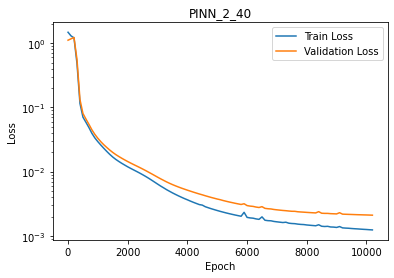

In [11]:
fig, ax = Training.plot_loss(pinn_trainer, pinn_net)

#### 4.5.3 Train PDNN

Given a training set $X_{PDNN} = ((\boldsymbol{\mu}^{(1)}, \operatorname{HF}(\boldsymbol{\mu}^{(1)})), \dots, (\boldsymbol{\mu}^{(n)}, \operatorname{HF}(\boldsymbol{\mu}^{(n)})))$ of parameter and high fidelity solution pairs for the PDE, we train a Projection-Driven Neural Network (PDNN) $\operatorname{N}_W(\boldsymbol{\mu})$ dependent on the weights and biases $W$ of the network to minimize the loss function
$$L_{PDNN}(X_{PDNN}; W) = \frac1n \sum_{i=1}^n \|\operatorname{N}_W(\boldsymbol{\mu}^{(i)}) - \tilde{\operatorname{HF}}(\boldsymbol{\mu}^{(i)})\|_2^2,$$
where for a given $\boldsymbol{\mu}$, $\tilde{\operatorname{HF}}(\boldsymbol{\mu})$ is the projection of $\operatorname{HF}(\boldsymbol{\mu})$ onto the reduced order solution space.

In [12]:
input_normalization_pdnn = Normalization.StandardNormalization(input_normalization=True)
output_normalization_pdnn = Normalization.StandardNormalization()

pdnn_net  = NN.RONN("PDNN", problem, reduction_method, n_hidden=2, n_neurons=40)
pdnn_loss = Losses.PDNN_Loss(pdnn_net, output_normalization_pdnn)
data      = RONNData.RONNDataLoader(pdnn_net, validation_proportion=0.2)
optimizer = torch.optim.Adam(pdnn_net.parameters(), lr=0.001)

pdnn_trainer = Training.PDNNTrainer(
    pdnn_net, data, pdnn_loss, optimizer,
    input_normalization_pdnn, num_epochs=10000
)

loaded, starting_epoch = IO.initialize_parameters(
    pdnn_net, data, pdnn_trainer, optimizer
)

In [13]:
pdnn_trainer.train()

0 1.08828451949316 	Loss(validation) = 0.9549082263037518
100 0.290290965229601 	Loss(validation) = 0.16685742804727344
200 0.1986716242102225 	Loss(validation) = 0.15404292218538068
300 0.10419965973757724 	Loss(validation) = 0.12654779106108013
400 0.034518546133512594 	Loss(validation) = 0.042173206912598966
500 0.022592255178325107 	Loss(validation) = 0.02823589874925713
600 0.016652556203038554 	Loss(validation) = 0.02065323575297147
700 0.012949337162776643 	Loss(validation) = 0.015507648764693467
800 0.011175605896710046 	Loss(validation) = 0.013774851067425853
900 0.010127303919107714 	Loss(validation) = 0.01344610636825166
1000 0.009268127071051525 	Loss(validation) = 0.013565830066669934
1100 0.00849038930855514 	Loss(validation) = 0.013636146837794271
1200 0.007784989143449748 	Loss(validation) = 0.01364836860184707
1300 0.007161654493715008 	Loss(validation) = 0.013554516758261245
1400 0.006627568697793513 	Loss(validation) = 0.013252855717920505
1500 0.00616971233641882 	L

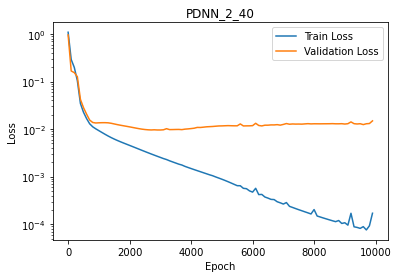

In [14]:
fig, ax = Training.plot_loss(pdnn_trainer, pdnn_net)

#### 4.5.4 Train PRNN

We train a Physics-Reinforced Neural Network (PRNN) $N_W(\boldsymbol{\mu})$ dependnent on the weights and biases $W$ of the network to minimize the loss function

$$L_{PRNN}(X_{PINN}, X_{PDNN}; W) = L_{PINN}(X_{PINN}; W) + \omega L_{PDNN}(X_{PDNN}; W),$$

where $\omega$ is a scaling parameter which can be chosen freely.

In [15]:
input_normalization_prnn = Normalization.StandardNormalization(input_normalization=True)
output_normalization_prnn = Normalization.StandardNormalization()

omega = 1.
prnn_net  = NN.RONN(f"PRNN_{omega}", problem, reduction_method, n_hidden=2, n_neurons=40)
prnn_loss = Losses.PRNN_Loss(prnn_net, output_normalization_prnn, omega=omega)
data      = RONNData.RONNDataLoader(prnn_net, validation_proportion=0.2,
                                    num_without_snapshots=100)
optimizer = torch.optim.Adam(prnn_net.parameters(), lr=0.001)

prnn_trainer = Training.PRNNTrainer(
    prnn_net, data, prnn_loss, optimizer,
    input_normalization_prnn, num_epochs=10000
)

loaded, starting_epoch = IO.initialize_parameters(
    prnn_net, data, prnn_trainer, optimizer
)

In [16]:
prnn_trainer.train()

Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
0 3.057158947557377 	Loss(validation) = 2.4784490837243447
100 1.4574135045386123 	Loss(validation) = 1.314195358442281
200 0.37846038696034606 	Loss(validation) = 0.3236975239922965
300 0.19443789247967003 	Loss(validation) = 0.1759136132084095
400 0.1423790946817979 	Loss(validation) = 0.134934823414428
500 0.1165408182596947 	Loss(validation) = 0.11350302381507194
600 0.10303423837491912 	Loss(validation) = 0.10224653225274515
700 0.09312908119571386 	Loss(validation) = 0.09340741473040093
800 0.0834271853067675 	Loss(validation) = 0.08411975559153576
900 0.07338206089824903 	Loss(validation) = 0.07461848391635674
1000 0.0649063030016338 	Loss(validation) = 0.06699999482902785
1100 0.05881892295573978 	Loss(validation) = 0.06142408752316353
1200 0.053940765871806885 	Loss(validation) = 0.056623527415326926
1300 0.04957781992937977 	Loss(validation) = 0.05

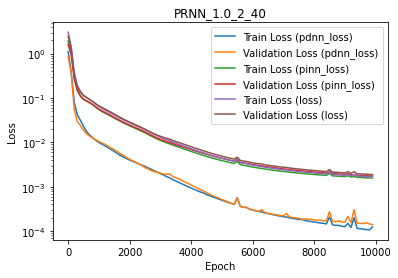

In [17]:
fig, ax = Training.plot_loss(prnn_trainer, prnn_net, separate=True)

### 4.6. Perform an error analysis

#### 4.6.1 Reduction Method Error Analysis

In [18]:
reduction_method.initialize_testing_set(10)
reduction_method.error_analysis()

=         UnsteadyThermalBlock1POD POD-Galerkin error analysis begins          =

###################################### 0 #######################################
# t = 0.05
# t = 0.1
# t = 0.15
# t = 0.2
# t = 0.25
# t = 0.3
# t = 0.35
# t = 0.4
# t = 0.45
# t = 0.5
# t = 0.55
# t = 0.6
# t = 0.65
# t = 0.7
# t = 0.75
# t = 0.8
# t = 0.85
# t = 0.9
# t = 0.95
# t = 1
# t = 1.05
# t = 1.1
# t = 1.15
# t = 1.2
# t = 1.25
# t = 1.3
# t = 1.35
# t = 1.4
# t = 1.45
# t = 1.5
# t = 1.55
# t = 1.6
# t = 1.65
# t = 1.7
# t = 1.75
# t = 1.8
# t = 1.85
# t = 1.9
# t = 1.95
# t = 2
# t = 2.05
# t = 2.1
# t = 2.15
# t = 2.2
# t = 2.25
# t = 2.3
# t = 2.35
# t = 2.4
# t = 2.45
# t = 2.5
# t = 2.55
# t = 2.6
# t = 2.65
# t = 2.7
# t = 2.75
# t = 2.8
# t = 2.85
# t = 2.9
# t = 2.95
# t = 3
# t = 3.05
Total time steps 61 (0 rejected, 0 SNES fails)
###################################### 1 #######################################
# t = 0.05
# t = 0.1
# t = 0.15
# t = 0.2
# t = 0.25
# t = 0.3
# t = 0.35


#### 4.6.2 PINN Error Analysis

In [19]:
test_mu = torch.tensor(reduction_method.testing_set)

In [20]:
_ = ErrorAnalysis.error_analysis_fixed_net(
    pinn_net, test_mu, input_normalization_pinn, output_normalization_pinn, relative=False
)

# t = 0.05
# t = 0.1
# t = 0.15
# t = 0.2
# t = 0.25
# t = 0.3
# t = 0.35
# t = 0.4
# t = 0.45
# t = 0.5
# t = 0.55
# t = 0.6
# t = 0.65
# t = 0.7
# t = 0.75
# t = 0.8
# t = 0.85
# t = 0.9
# t = 0.95
# t = 1
# t = 1.05
# t = 1.1
# t = 1.15
# t = 1.2
# t = 1.25
# t = 1.3
# t = 1.35
# t = 1.4
# t = 1.45
# t = 1.5
# t = 1.55
# t = 1.6
# t = 1.65
# t = 1.7
# t = 1.75
# t = 1.8
# t = 1.85
# t = 1.9
# t = 1.95
# t = 2
# t = 2.05
# t = 2.1
# t = 2.15
# t = 2.2
# t = 2.25
# t = 2.3
# t = 2.35
# t = 2.4
# t = 2.45
# t = 2.5
# t = 2.55
# t = 2.6
# t = 2.65
# t = 2.7
# t = 2.75
# t = 2.8
# t = 2.85
# t = 2.9
# t = 2.95
# t = 3
# t = 3.05
Total time steps 61 (0 rejected, 0 SNES fails)
# t = 0.05
# t = 0.1
# t = 0.15
# t = 0.2
# t = 0.25
# t = 0.3
# t = 0.35
# t = 0.4
# t = 0.45
# t = 0.5
# t = 0.55
# t = 0.6
# t = 0.65
# t = 0.7
# t = 0.75
# t = 0.8
# t = 0.85
# t = 0.9
# t = 0.95
# t = 1
# t = 1.05
# t = 1.1
# t = 1.15
# t = 1.2
# t = 1.25
# t = 1.3
# t = 1.35
# t = 1.4
# t = 1.45
# t = 1.5
# t =

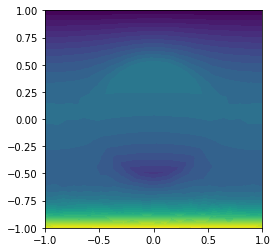

In [21]:
ErrorAnalysis.plot_solution_difference(
    pinn_net, (8.0, -1.0), input_normalization_pinn, output_normalization_pinn
)

#### 4.6.3 PDNN Error Analysis

In [22]:
_ = ErrorAnalysis.error_analysis_fixed_net(
    pdnn_net, test_mu, input_normalization_pdnn, output_normalization_pdnn, relative=False
)

#################################### N = 6 #####################################
ERROR	NN-HF			NN-RO			RO-HF
min	0.012111615735408737	0.010970619172553922	0.0
mean	0.3628516535326086	0.36261808091164077	0.006241691858928853
max	1.2120287494681727	1.2120602517755852	0.03066620754194809


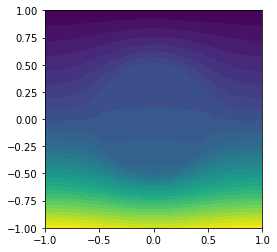

In [23]:
ErrorAnalysis.plot_solution_difference(
    pdnn_net, (8.0, -1.0), input_normalization_pdnn, output_normalization_pdnn
)

#### 4.6.4 PRNN Error Analysis

In [24]:
_ = ErrorAnalysis.error_analysis_fixed_net(
    prnn_net, test_mu, input_normalization_prnn, output_normalization_prnn, relative=False
)

#################################### N = 6 #####################################
ERROR	NN-HF			NN-RO			RO-HF
min	0.0008414277457070783	0.00072306345645741	0.0
mean	0.01857047138459447	0.016803199693532174	0.006241691858928853
max	0.11783322825570836	0.10704917840806218	0.03066620754194809


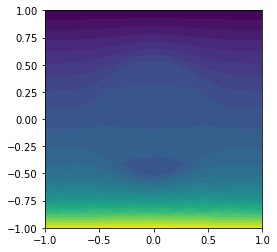

In [25]:
ErrorAnalysis.plot_solution_difference(
    prnn_net, (8.0, -1.0), input_normalization_prnn, output_normalization_prnn
)

#### 4.6.5 Neural Network Error Comparison

In [26]:
nets = dict()
nets["pinn_net"] = pinn_net
nets["pdnn_net"] = pdnn_net
nets["prnn_net"] = prnn_net

input_normalizations = dict()
input_normalizations["pinn_net"] = input_normalization_pinn
input_normalizations["pdnn_net"] = input_normalization_pdnn
input_normalizations["prnn_net"] = input_normalization_prnn

output_normalizations = dict()
output_normalizations["pinn_net"] = output_normalization_pinn
output_normalizations["pdnn_net"] = output_normalization_pdnn
output_normalizations["prnn_net"] = output_normalization_prnn

_ = ErrorAnalysis.error_analysis_by_network(
    nets, test_mu, input_normalizations, output_normalizations, relative=False
)

#####################################################################################
Mean Error for 6 Basis Functions
Network		NN-HF			NN-RO			RO-HF
pinn_net	0.018399945025163292	0.016594052704747293	0.006241691858928853
pdnn_net	0.3628516535326086	0.36261808091164077	0.006241691858928853
prnn_net	0.01857047138459447	0.016803199693532174	0.006241691858928853
#####################################################################################


### 4.7. Perform a speedup analysis

In [ ]:
reduction_method.initialize_testing_set(10)
reduction_method.speedup_analysis()